In [3]:
### Use gpd environment (a clean environment for geopandas)

In [16]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np
import pylab as pl
import os
from IPython import display
from subprocess import call
from datetime import datetime
import subprocess
import sys
sys.path.append('/Users/vsriniv/Documents/Research/Github/PatchSim')
import patchsim as sim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# ## Note that the v2 OD_Matrix has both src-dest and dest-src travel times.
# od_matrix = pd.read_csv('../data/pop_travel/OD_Matrix_v2.csv')
# od_matrix['Grav'] = (od_matrix.Origin_Pop*od_matrix.Destination_Pop)/(od_matrix.Travel_Time**2)
# od_matrix = od_matrix.assign(norm_flow=od_matrix.Grav.div(od_matrix.groupby(['Origin']).Grav.transform('sum')))
# od_matrix = od_matrix[['Origin','Destination','norm_flow']]

# hz = od_matrix.Origin.unique()
# non_commute=0.7
# df = pd.DataFrame({'Origin':hz,'Destination':hz,'norm_flow':np.repeat(non_commute,len(hz))})
# od_matrix.norm_flow = od_matrix.norm_flow*(1-non_commute)
# od_matrix = od_matrix.append(df[['Origin','Destination','norm_flow']])
# od_matrix['temp'] = 0
# od_matrix.Origin = od_matrix.Origin.str.replace(' ','_')
# od_matrix.Destination = od_matrix.Destination.str.replace(' ','_')
# od_matrix[['Origin','Destination','temp','norm_flow']].to_csv('../data/patchsim/grav_drc_v2.csv',sep=' ',index=None,header=None)

In [3]:
# df = pd.read_csv('../data/pop_travel/OD_Matrix_v2.csv')
# df = df[['Origin','Origin_Pop']].drop_duplicates()
# df.Origin = df.Origin.str.replace(' ','_')
# df.to_csv('../data/patchsim/pop_drc_v2.csv',sep=' ',index=None,header=None)

In [4]:
cfgs = sim.read_config('../data/patchsim/cfg.txt')
sim.run_disease_simulation(cfgs,write_epi=True)

In [52]:
out_df = pd.read_csv('../outputs/sample.out',delimiter=' ',header=None,index_col=0)
out_df.index = out_df.index.str.replace('_',' ')
out_wk = out_df.groupby((out_df.columns - 1)// 7, axis=1).sum()
wk_range = out_wk.columns[:-1]
out_wk = out_wk[wk_range]
out_wk.index = out_wk.index.str.replace('_',' ')
out_wk.sum().cumsum()

0       7
1       7
2       7
3       7
4       7
5       7
6       7
7       8
8      15
9      22
10     29
11     42
12     56
13     76
14    113
15    178
16    284
dtype: int64

In [53]:
gdf = gpd.read_file('../data/shapefile/healthzones_v2/DRC_Districts.shp').set_index('ADM2_NAME')
gdf = gdf.join(out_wk)

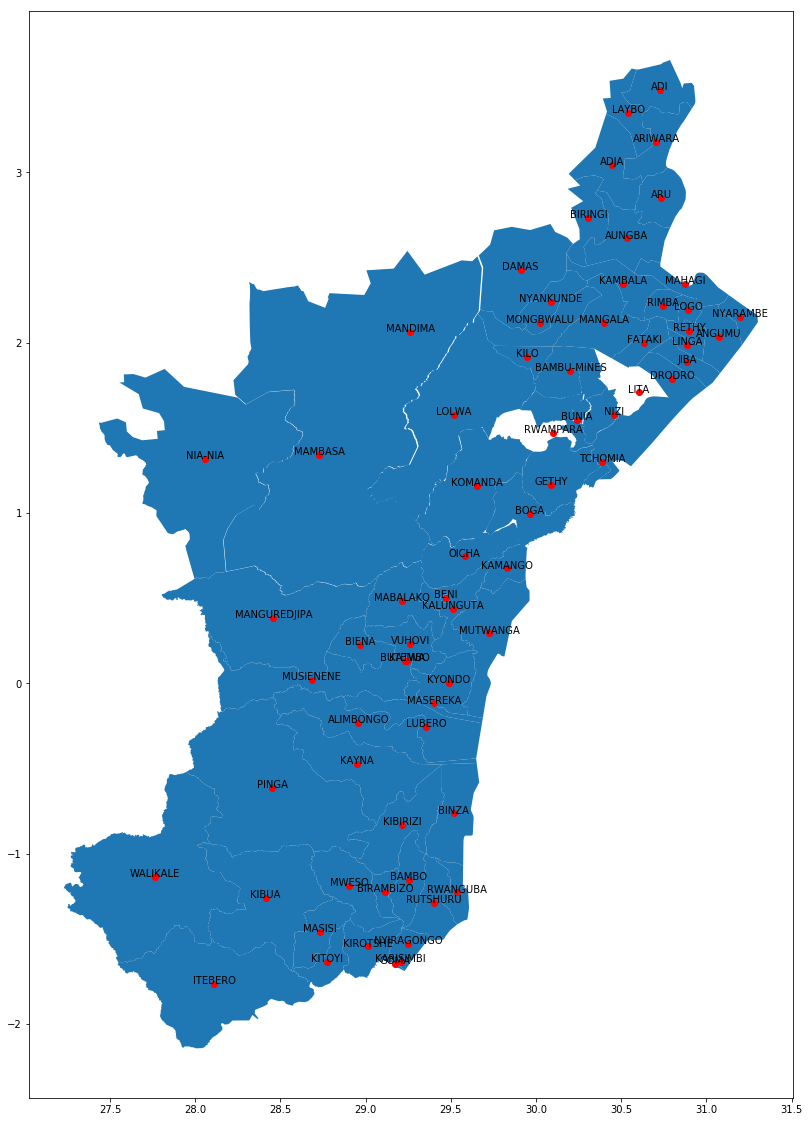

In [55]:
mask = gdf.ADM1_NAME.isin(['ITURI','NORD KIVU'])
gdf[mask].plot(figsize=(20,20))
for idx, row in gdf[mask].iterrows():
    plt.plot(row['CENTER_LON'],row['CENTER_LAT'],'ro')
    plt.annotate(s=idx, xy=(row['CENTER_LON'],row['CENTER_LAT']),horizontalalignment='center')

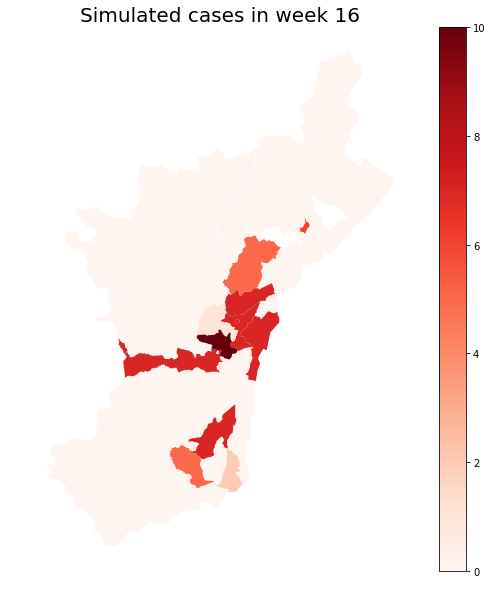

In [56]:
count=0
for wk in wk_range:
    f = plt.figure(figsize=(10,10))
    ax = plt.gca()
    plt.axis('off')
    plt.title('Simulated cases in week {}'.format(wk),fontsize=20)
    gdf[(gdf.ADM1_NAME.isin(['ITURI','NORD KIVU']))].plot(ax=ax,column=wk,cmap='Reds',vmin=0,vmax=10,legend=True)
    #gdf.plot(ax=ax,column=wk,cmap='Reds',vmin=0,vmax=10,legend=True)
    display.clear_output(wait=True)
    display.display(pl.gcf())    
    plt.savefig('../plots/{:02d}.png'.format(count),bbox_inches='tight')
    count+=1
    plt.close()
call("convert -delay 100 -loop 1 ../plots/*.png ../plots/sim_anim_nk.gif".split(' '))
[os.remove('../plots/'+x) for x in os.listdir('../plots') if '.png' in x];

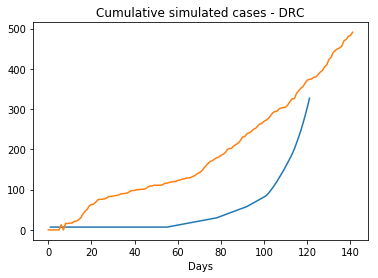

In [57]:
evd_df = pd.read_csv('../data/ebola_drc_nordkivu/data/ebola_drc-all.csv').fillna(0)
evd_df['Date'] = evd_df.date.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
ax = out_df.sum().cumsum().plot()
gt = evd_df[evd_df.health_zone=='all'].total_c.values
ax.plot(gt)
plt.title('Cumulative simulated cases - DRC')
plt.xlabel('Days')
plt.savefig('../plots/sim_epicurve.png',dpi=100)

In [58]:
out_wk['Total'] = out_wk[wk_range].sum(axis=1)
temp_df = out_wk.sort_values('Total',ascending=False)[['Total']]
temp_df['risk_index'] = temp_df.Total/temp_df.Total.sum()
temp_df.head(10)

,Total,risk_index
0,,
VUHOVI,165,0.580986
MUSIENENE,18,0.063380
OICHA,18,0.063380
MUTWANGA,17,0.059859
KALUNGUTA,15,0.052817
BENI,14,0.049296
KIBIRIZI,13,0.045775
BUNIA,6,0.021127
MWESO,5,0.017606
